# Projet P4 : Anticipez les besoins en consommation de bâtiments - Modèle 2e target (émissions CO2)

### Rappel des étapes du projet :

Des relevés de consommations et émissions des bâtiments non destinés à l’habitation ont été effectués par les agents de la ville en 2016. A partir de ces relevé, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels ces données n'ont pas été mesurées.

- <b> Etape préliminaire : </b> Importation des données et description des fichiers ( --> NoteBook0 : Analyse exploratoire )
- <b> Etape 1 : </b> Analyse exploratoire des datasets et premiers feature engineering ( --> NoteBook0 : Analyse exploratoire ) 
- <b> Etape 2 : </b> Développement et simulation d'un premier modèle ( --> NoteBook1 : Implémentation modèle )
- <b> Etape 3 : </b> Amélioration du feature engineering ( --> NoteBook1 : Implémentation modèle )
- <b> Etape 4 : </b> Simulation d'autres modèles et choix du modèle final ( --> NoteBook1 : Implémentation modèle )
- <b> Etape 5 : </b> Analyse de la "feature importance" globale et locale ( --> NoteBook1 : Implémentation modèle )
- <b> Etape 6 : </b> Analyse de l'influence de l'EnergyStarScore ( --> NoteBook1 : Implémentation modèle )
- <b> Etape 7 : </b> Simulation de la 2ème target ( --> NoteBook2 : Modèle 2e target )

#### Pour l'étape 7 dans ce notebook on reprend les étapes 4 à 6 (avec une étape préliminaire de chargement des données) sur notre 2e target à prédire, les émissions de CO2.

### Environnement de travail et librairies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modele selection
from sklearn import model_selection
from sklearn.model_selection import KFold

# Estimators :
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge # RidgeCV
from sklearn.linear_model import Lasso # LassoCV
from sklearn.linear_model import ElasticNet # ElasticNetCV pour faire la validation croisée directement
from sklearn.linear_model import LogisticRegression # Pour la classification
from sklearn.svm import LinearSVR # LinearSVC pour la classification
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor # RandomForestClassifier pour la classification
from sklearn.ensemble import GradientBoostingRegressor # GradientBoostingClassifier pour la classification
from sklearn import kernel_ridge # Regression ridge à noyau

# Metrics :
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Standardiser les données
from sklearn.preprocessing import StandardScaler
from math import log

# Feature importance :
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

## Etape préliminaire : préparation des données et outils pour tester les modèles

1. Chargement des données
2. Création du modèle de données
3. Scinder en train / test
4. Normaliser les variables
5. Implémenter un prédicteur naïf
6. Fonction pour implémenter le modèle et l'évaluer

### 1. Chargement des données

In [68]:
### Récupérer le fichier cleané dans le notebook 1
building_energy_MODELE = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P4\\data\\Building_Energy_MODELE.csv", index_col=0)
building_energy_MODELE.head()

,Parking_yes_no,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,Steam_%,Electricity_%,NaturalGas_%,NumberofBuildings,NumberofFloors,Latitude,...,TLPUT_Refrigerated Warehouse,TLPUT_Restaurant,TLPUT_Retail Store,TLPUT_Self-Storage Facility,TLPUT_Social/Meeting Hall,TLPUT_Strip Mall,TLPUT_Supermarket/Grocery Store,TLPUT_Swimming Pool,TLPUT_Vocational School,TLPUT_Worship Facility
0,0,88434,0,60.0,0.277302,0.546060,0.176638,1.0,12,47.61220,...,0,0,0,0,0,0,0,0,0,0
1,1,88502,15064,61.0,0.000000,0.386609,0.613391,1.0,11,47.61317,...,0,1,0,0,0,0,0,0,0,0
2,1,759392,196718,43.0,0.297113,0.682307,0.020579,1.0,41,47.61393,...,0,0,0,0,0,0,0,0,0,0
3,0,61320,0,56.0,0.325913,0.407519,0.266567,1.0,10,47.61412,...,0,0,0,0,0,0,0,0,0,0
4,1,113580,62000,75.0,0.000000,0.378802,0.621198,1.0,18,47.61375,...,0,0,0,0,0,0,0,1,0,0


### 2. Création du modèle de données

In [69]:
# Filtre sur les hôpitaux (10 bâtiments)
building_energy_filtre = building_energy_MODELE[building_energy_MODELE['PPT_Hospital'] < 1]
# Filtre sur l'individu atypique (558)
building_energy_filtre = building_energy_filtre.drop(558)
# Variables à conserver pour constituer le modèle : 
var_modele = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Steam_%',
              'Electricity_%', 'NaturalGas_%', 'NumberofBuildings', 'NumberofFloors', 'Latitude',
              'Longitude', 'Age_batiment']
selected_var = building_energy_filtre.filter(regex='^PPT_')
target = ['TotalGHGEmissions']

building_energy_var_MODELE = pd.concat([building_energy_filtre[var_modele], selected_var,building_energy_filtre[target]], axis=1)
building_energy_var_MODELE.shape

(1487, 32)

In [70]:
# Soit Target la variable cible à prédire
target = building_energy_var_MODELE['TotalGHGEmissions']
# Soit X le df contenant les données qui vont entrer dans le modèle
X = building_energy_var_MODELE.iloc[:, :-1]

### 3. Scinder les données en train / test

In [71]:
# Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 25% des données.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,target, test_size=0.25, random_state=30)

### 4. Normaliser les variables

In [72]:
# standardiser les données :
# standardiser les données train et test :
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
# On ajoute 1 pour éviter log(0) et on transforme en log la variable target :
series_train = (y_train.astype(float)+1)
y_train = series_train.apply(lambda x: log(x))
series_test = (y_test.astype(float)+1)
y_test = series_test.apply(lambda x: log(x))

### 5. Implémenter un prédicteur naïf

In [73]:
# Prédictions le prédicteur naïf = moyenne des données y_train:
# Calculer la moyenne de y_train
y_train_mean = np.exp(y_train).mean()

# Créer une série Pandas des valeurs de y_train_mean
y_pred_series_naif = pd.Series([y_train_mean] * X_test.shape[0])
# Convertir la série en DataFrame si nécessaire
y_pred_naif = pd.DataFrame(y_pred_series_naif, columns=['Predicted_Value'])

# Performances du modèle = Baseline
print(f"Root Mean Squared Error (RMSE)(y, y_pred): {np.sqrt(mean_squared_error((np.exp(y_test)-1), y_pred_naif)):.2e}")
# RMSE baseline modele = 1.99e+02

Root Mean Squared Error (RMSE)(y, y_pred): 2.60e+02


### 6. Fonction pour implémenter un modèle et l'évaluer

In [9]:
# Faire une fonction pour définir un modèle, tester les hyper-paramètres par validation croisée, 
# entrainer le modele choisi et évaluer les indicateurs de performance du modèle

def modele_estime(estimator,parametres,folds, X1,y1,X2,y2):
    """Renvoie le résultat du modèle avec les principaux indicateurs de performance
        0. X1,y1 = train set - X2,y2 = test set
        1. Définition du modèle avec la liste de paramètres à tester
        2. Entrainement du modèle sur le train 
        3. Les meilleurs paramètres du modèle
        4. Le score R² du modèle sur le train
        5. Prédictions pour X_test, R² sur le test et calcul de la RMSE
        6. Temps d'entrainement du modèle """
    
    # 1. Définition du modèle avec la liste de paramètres à tester
    # RandomSearch à la place de GridSearch est moins exhaustif pour tester les paramètres 
    # (échantillon aléatoire des hyper paramètres) mais prend moins de temps
    modele = model_selection.GridSearchCV(
    estimator, # un estimateur
    param_grid=parametres,
    cv=folds,      # nombre de folds de validation croisée
    scoring='r2'   # score à optimiser
    )
    # 2. Entrainement du modèle sur le jeu d'entraînement
    modele.fit(X1, y1)
    
    # 3. Les meilleurs paramètres du modèle
    print(f"Les meilleurs paramètres du modèle sont : {modele.best_params_}")
    
    # 4. Le score R² du modèle 
    print(f"Score R² sur le train : {modele.best_score_}")
    
    # 5. Prédictions pour X_test et calcul de la RMSE pour identifier le meilleur modèle
    # GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement
    y_pred = modele.predict(X2)
    print(f"Score R² test : {r2_score(y2, y_pred)}")
    # On peut calculer l'écart entre les vraies valeurs de test (y_test) et celles prédites par le modèle.
    # On applique np.exp sur mes prédictions en log pour repasser sur les vrai valeurs
    print(f"Root_mean_squared_error(y, y_pred): {np.sqrt(mean_squared_error((np.exp(y2-1)), (np.exp(y_pred-1)))):.2e}")
    
    # 6. Temps d'entrainement du modèle :
    temps_moyen_ajustement = modele.cv_results_['mean_fit_time'][modele.best_index_]
    print("Temps moyen d'ajustement du meilleur modèle (secondes):", temps_moyen_ajustement)
    # Temps d'inférence du modèle :
    temps_moyen_inference = modele.cv_results_['mean_score_time'][modele.best_index_]
    print("Temps moyen d'inférence du meilleur modèle (secondes):", temps_moyen_inference)
    
    return modele

## Etape 4 : simulation de modèles et choix du modèle final

#### 1. ElasticNet

In [11]:
parametres = {
    'alpha': [0.1,0.5,1,10], # 'alpha': [0.01,0.1,1,10],
    'l1_ratio': [.1,.2,.3,.4, .5, .7, .9, .95, .99,1],
    'fit_intercept': [True, False],
    'precompute': [True, False]
    }
modele = modele_estime(ElasticNet(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.1, 'precompute': True}
Score R² sur le train : 0.6599106568182374
Score R² test : 0.6701491018829716
Root_mean_squared_error(y, y_pred): 8.62e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 0.007778978347778321
Temps moyen d'inférence du meilleur modèle (secondes): 0.0006211280822753906


#### 2. SVM à noyaux

In [13]:
parametres = {
    'kernel':['poly'], #'kernel':['poly','rbf','sigmoid','linear'],
    'degree':[4], #[2,3,4]
    'gamma':['auto'], #'gamma':['scale', 'auto'],
    'coef0':[10], #'coef0':[0,0.1,1,10],
    'C': [0.001], #'C': [0.001,0.01,0.1,1,10],
    'epsilon': [0.01] #'epsilon': [0.001,0.01,0.1,0.2]
}
modele = modele_estime(SVR(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'C': 0.001, 'coef0': 10, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Score R² sur le train : 0.7490791559508446
Score R² test : 0.7400046524566901
Root_mean_squared_error(y, y_pred): 8.81e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 0.100742769241333
Temps moyen d'inférence du meilleur modèle (secondes): 0.012385368347167969


#### 3. Modèle ensembliste parallèle : RandomForest

In [14]:
parametres = {
    'n_estimators': [100], #'n_estimators': [50,100],
    'max_depth': [20], #'max_depth': [2,5,10,15,20,None],
    'criterion': ['squared_error'], #'criterion': ['squared_error', 'absolute_error'],
    
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10],
    # 'min_samples_leaf': [2,5,10],
    'max_features': [None] # [5,10,20,None] racine du nb de variables
}
modele = modele_estime(RandomForestRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'criterion': 'squared_error', 'max_depth': 20, 'max_features': None, 'n_estimators': 100}
Score R² sur le train : 0.7552624699797649
Score R² test : 0.739039363660476
Root_mean_squared_error(y, y_pred): 6.48e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 2.5509270668029784
Temps moyen d'inférence du meilleur modèle (secondes): 0.01902484893798828


#### 4. Modèle ensembliste séquentiel : GradientBoosting

In [18]:
parametres = {
    'loss':['squared_error'], #'loss':['squared_error','absolute_error','huber','quantile'],
    'learning_rate': [0.1], #'learning_rate': [0.001,0.01,0.1,10,100],
    'n_estimators': [100], #'n_estimators': [20,50,100,150,200],
    'max_depth': [10], #'max_depth': [2,5,10,15,20],
    'subsample': [0.2], #'subsample': [0.01,0.1,0.2],
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10,15,20],
    # 'min_samples_leaf': [2], #'min_samples_leaf': [2,5,10,15,20],
    'alpha': [0.01,0.1] #[0.0001,0.001,0.01,0.1, 1, 10, 100]
}
modele = modele_estime(GradientBoostingRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 0.1, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.2}
Score R² sur le train : 0.7634245049790929
Score R² test : 0.7463175558924453
Root_mean_squared_error(y, y_pred): 5.67e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 0.6640284061431885
Temps moyen d'inférence du meilleur modèle (secondes): 0.0024416446685791016


#### 5. Modèle final : Gradient Boosting

In [76]:
parametres = {
    'loss':['squared_error'], #'loss':['squared_error','absolute_error','huber','quantile'],
    'learning_rate': [0.1], #'learning_rate': [0.001,0.01,0.1,10,100],
    'n_estimators': [100], #'n_estimators': [20,50,100,150,200],
    'max_depth': [10], #'max_depth': [2,5,10,15,20],
    'subsample': [0.2], #'subsample': [0.01,0.1,0.2],
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10,15,20],
    # 'min_samples_leaf': [2], #'min_samples_leaf': [2,5,10,15,20],
    # 'alpha': [0.1] #[0.0001,0.001,0.01,0.1, 1, 10, 100]
}
modele = modele_estime(GradientBoostingRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.2}
Score R² sur le train : 0.7513430722299888
Score R² test : 0.746027189719881
Root_mean_squared_error(y, y_pred): 6.30e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 0.8875779628753662
Temps moyen d'inférence du meilleur modèle (secondes): 0.007131767272949219


In [20]:
# Enregistrer le meilleur modele pour en extraire les informations
gradient_boosting = modele.best_estimator_
y_pred = gradient_boosting.predict(X_test)

In [28]:
X_test_df = pd.DataFrame(X_test, columns=np.array(X.columns))
# Concaténer les colonnes calculées avec X_test_df
X_test_df['y_test_exp'] = np.exp(y_test)
X_test_df['y_pred_exp'] = np.exp(y_pred)
X_test_df['type_batiment'] = building_energy_MODELE['PrimaryPropertyType']
X_test_df.head()

# Filtrer la colonne 'PrimaryPropertyType' pour obtenir uniquement les indices présents dans y_test
filtered_property_type = building_energy_MODELE.loc[y_test.index, 'PrimaryPropertyType']
# Concaténer cette colonne filtrée avec y_test
result = pd.concat([filtered_property_type, y_test], axis=1)
# Renommer les colonnes pour une meilleure clarté
result.columns = ['PrimaryPropertyType', 'y_test']
result['y_test_exp'] = np.exp(result['y_test'])
result['y_pred_exp'] = np.exp(y_pred)

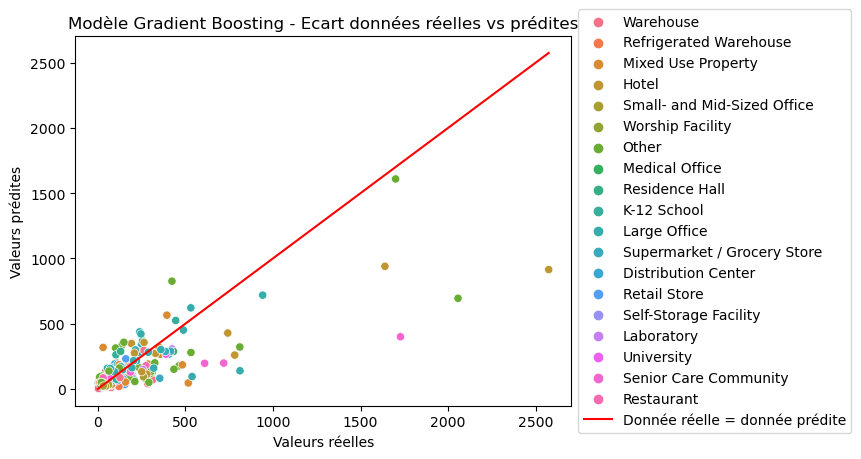

In [30]:
# Tracer un nuage de points entre les valeurs réelles et prédites
# plt.scatter(np.exp(y_test), np.exp(y_pred), label='Données réelles vs prédites')

sns.scatterplot(data=result, x='y_test_exp', y='y_pred_exp', hue='PrimaryPropertyType')

# Tracer la droite de régression linéaire entre valeurs réelles et prédites
max_value = max(np.max(np.exp(y_test)), np.max(np.exp(y_pred)))
plt.plot([0, max_value], [0, max_value], color='red', label='Donnée réelle = donnée prédite')

# Ajouter des labels et un titre
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Modèle Gradient Boosting - Ecart données réelles vs prédites')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## ETAPE 5 : Analyse de l'importance des features

ETAPE 5

- analyse de l'importance des caractéristiques globales dans le modèle final
- compréhension des caractéristiques qui ont le plus d'influence sur les prédictions
- représentations graphiques claires de ces différentes influences

In [31]:
X_train_df = pd.DataFrame(X_train, columns=np.array(X.columns))

In [32]:
# Determiner les SHAP values
explainer = shap.TreeExplainer(gradient_boosting)
shap_values = explainer(X_train_df)

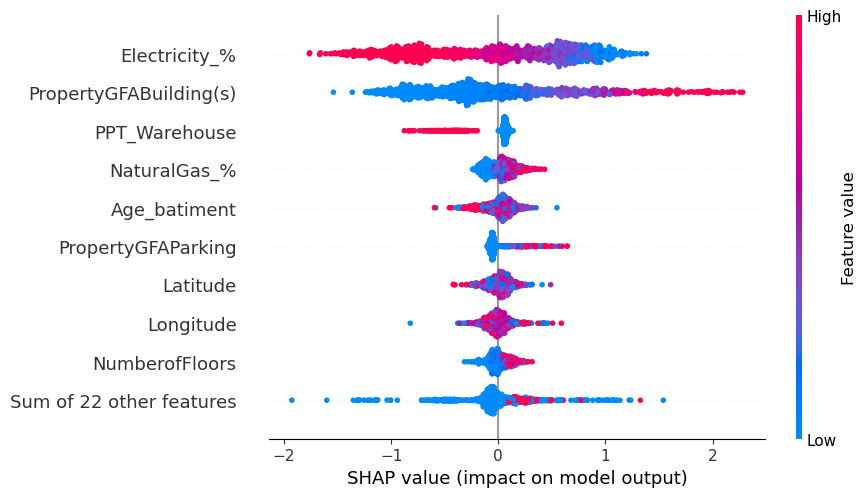

In [34]:
shap.plots.beeswarm(shap_values,max_display=10)

## ETAPE 6 : Analyse de l'influence de l'EnergyStarScore

ETAPE 6

- Déterminer l'importance de cette caractéristique dans le modèle
- Faites un sous-ensemble du dataset permettant de tester correctement l’impact de cette caractéristique sur l’entraînement et les performances du modèle sélectionné.
- Testez l'entraînement de votre modèle avec et sans cette caractéristique.

#### 1. On filtre sur les données avec la variable ENERGYSTARScore renseignée

In [51]:
# Création du dataset pour tester l'influence de l'EnergyStarScore
building_energy_filtre = building_energy_MODELE[building_energy_MODELE['PPT_Hospital'] < 1]
# Filtre sur l'individu atypique (558)
building_energy_filtre = building_energy_filtre.drop(558)
building_energy_filtre = building_energy_filtre[building_energy_filtre['ENERGYSTARScore'].notna()]

# Variables à conserver pour constituer le modèle : 
var_modele = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Steam_%',
              'Electricity_%', 'NaturalGas_%', 'NumberofBuildings', 'NumberofFloors', 'Latitude',
              'Longitude', 'Age_batiment','ENERGYSTARScore']
selected_var = building_energy_filtre.filter(regex='^PPT_')
target = ['TotalGHGEmissions']

building_energy_MODELE_Score = pd.concat([selected_var,building_energy_filtre[var_modele], building_energy_filtre[target]], axis=1)
building_energy_MODELE_Score.shape

(969, 33)

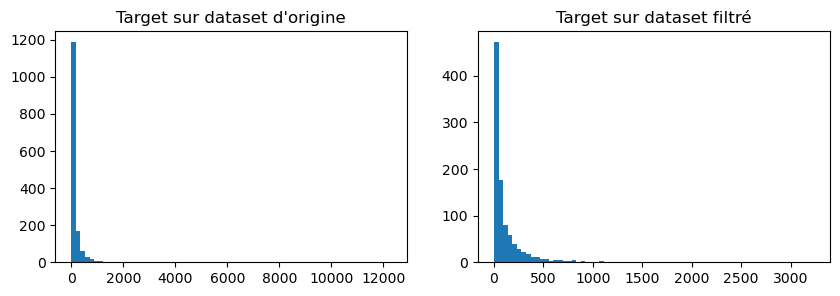

In [52]:
# Vérifier que la répartition des données reste la même sur les données filtrées : OK
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
axs[0].hist(building_energy_MODELE['TotalGHGEmissions'], bins=70)
axs[0].set_title("Target sur dataset d'origine")
    
axs[1].hist(building_energy_filtre['TotalGHGEmissions'], bins=70)
axs[1].set_title("Target sur dataset filtré")
    
plt.show()

In [53]:
# Soit Target la variable cible à prédire
target = building_energy_MODELE_Score['TotalGHGEmissions']

# Soit X le df contenant les données qui vont entrer dans le modèle
X = building_energy_MODELE_Score.iloc[:, :-1]
keep_ind = X.index

In [54]:
# Standardiser les données et passer au log la target
X_scaled = StandardScaler().fit_transform(X)
series = (target.astype(float)+1)
y = series.apply(lambda x: log(x))

In [55]:
# Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 25% des données.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled,y, test_size=0.25, random_state=20)

In [56]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(726, 32) (243, 32) (726,) (243,)


#### 2. On lance une seconde fois le modèle AVEC la variable ENERGYSTARScore

In [57]:
parametres = {
    'loss':['squared_error'], #'loss':['squared_error','absolute_error','huber','quantile'],
    'learning_rate': [0.001,0.01,0.1], #'learning_rate': [0.001,0.01,0.1,10,100],
    'n_estimators': [100], #'n_estimators': [20,50,100,150,200],
    'max_depth': [10,15,20], #'max_depth': [2,5,10,15,20],
    'subsample': [0.2], #'subsample': [0.01,0.1,0.2],
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10,15,20],
    # 'min_samples_leaf': [2], #'min_samples_leaf': [2,5,10,15,20],
    'alpha': [0.001,0.01,0.1] #[0.0001,0.001,0.01,0.1, 1, 10, 100]
}
modele = modele_estime(GradientBoostingRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 20, 'n_estimators': 100, 'subsample': 0.2}
Score R² sur le train : 0.8702817186456515
Score R² test : 0.8872439256765077
Root_mean_squared_error(y, y_pred): 2.88e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 0.6481542587280273
Temps moyen d'inférence du meilleur modèle (secondes): 0.006133604049682617


In [58]:
# Enregistrer le meilleur modele pour en extraire les informations
gradient_boosting = modele.best_estimator_
y_pred = gradient_boosting.predict(X_test)

#### 3. On fait tourner un premier modèle SANS la variable ENERGYSTARScore

In [59]:
y_test_Sscore = y_test
y_train_Sscore = y_train

In [60]:
# Supprimez la colonne 'ENERGYSTARScore' de X_train et X_test
X_train_Sscore = np.delete(X_train, -1, axis=1)
X_test_Sscore = np.delete(X_test, -1, axis=1)

In [61]:
parametres = {
    'loss':['squared_error'], #'loss':['squared_error','absolute_error','huber','quantile'],
    'learning_rate': [0.001,0.01,0.1], #'learning_rate': [0.001,0.01,0.1,10,100],
    'n_estimators': [100], #'n_estimators': [20,50,100,150,200],
    'max_depth': [10,15,20], #'max_depth': [2,5,10,15,20],
    'subsample': [0.2], #'subsample': [0.01,0.1,0.2],
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10,15,20],
    # 'min_samples_leaf': [2], #'min_samples_leaf': [2,5,10,15,20],
    'alpha': [0.001,0.01,0.1] #[0.0001,0.001,0.01,0.1, 1, 10, 100]
}
modele = modele_estime(GradientBoostingRegressor(),parametres,5,X_train_Sscore,y_train_Sscore,X_test_Sscore,y_test_Sscore)

Les meilleurs paramètres du modèle sont : {'alpha': 0.1, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 20, 'n_estimators': 100, 'subsample': 0.2}
Score R² sur le train : 0.7944627943022073
Score R² test : 0.8183009820730273
Root_mean_squared_error(y, y_pred): 3.50e+01
Temps moyen d'ajustement du meilleur modèle (secondes): 0.642412519454956
Temps moyen d'inférence du meilleur modèle (secondes): 0.00414118766784668


In [63]:
# Enregistrer le meilleur modele pour en extraire les informations
gradient_boosting_Sscore = modele.best_estimator_
y_pred_Sscore = gradient_boosting_Sscore.predict(X_test_Sscore)

#### 4. Analyse de l'importance de la variable ENERGYSTARScore

In [64]:
X_train_df = pd.DataFrame(X_train, columns=np.array(X.columns))

In [65]:
# Determiner les SHAP values
explainer = shap.TreeExplainer(gradient_boosting)
shap_values = explainer(X_train_df)

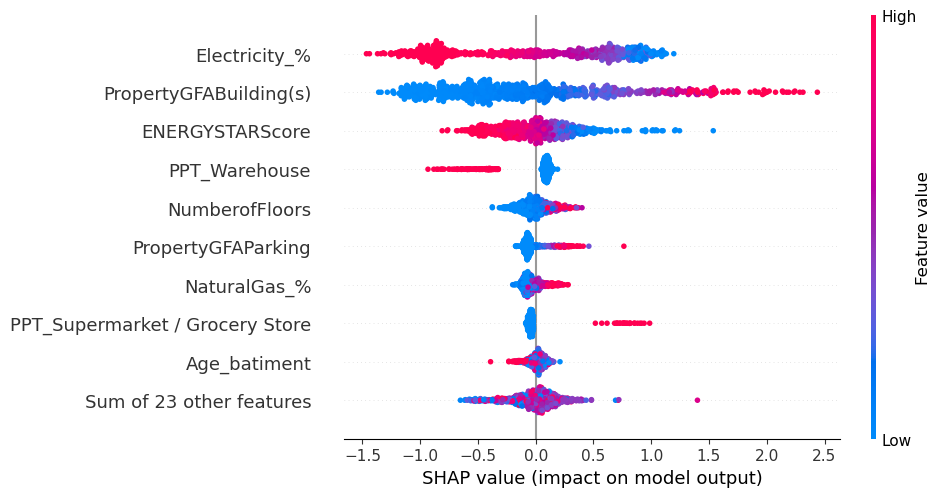

In [67]:
shap.plots.beeswarm(shap_values,max_display=10)